# Project 2 | ML | 2021-22

- João Santos, 76912
- João Carvalho, 106310

## Pneumonia Dataset

https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia

In [1]:
# Imports
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_addons as tfa

2022-06-24 23:29:05.983552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/joao/.mujoco/mujoco210/bin
2022-06-24 23:29:05.983578: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load images do Pandas DataFrame
filenames = tf.io.gfile.glob('./Curated X-Ray Dataset/*/*')
print(len(filenames))
filenames[:3]

data = pd.DataFrame()
for el in range(0, len(filenames)):
    target = filenames[el].split('/')[-2]
    path = filenames[el]
    
    data.loc[el, 'filename'] = path
    data.loc[el, 'class'] = target

print(data['class'].value_counts(dropna=False))
data

9208
Normal                 3270
Pneumonia-Bacterial    3001
Pneumonia-Viral        1656
COVID-19               1281
Name: class, dtype: int64


,filename,class
0,./Curated X-Ray Dataset/COVID-19/COVID-19 (109...,COVID-19
1,./Curated X-Ray Dataset/COVID-19/COVID-19 (118...,COVID-19
2,./Curated X-Ray Dataset/COVID-19/COVID-19 (244...,COVID-19
3,./Curated X-Ray Dataset/COVID-19/COVID-19 (521...,COVID-19
4,./Curated X-Ray Dataset/COVID-19/COVID-19 (135...,COVID-19
...,...,...
9203,./Curated X-Ray Dataset/Normal/Normal (3139).jpg,Normal
9204,./Curated X-Ray Dataset/Normal/Normal (1542).jpg,Normal
9205,./Curated X-Ray Dataset/Normal/Normal (245).jpg,Normal
9206,./Curated X-Ray Dataset/Normal/Normal (173).jpg,Normal


In [3]:
# Shuffle data and make class numerical
data = shuffle(data)
data.reset_index(drop=True, inplace=True)

change = {
'Normal' : '0',
'Pneumonia-Bacterial': '1',
'Pneumonia-Viral' : '2',
'COVID-19' : '3',
}

data['class'] = data['class'].map(change)
data

,filename,class
0,./Curated X-Ray Dataset/Pneumonia-Viral/Pneumo...,2
1,./Curated X-Ray Dataset/Normal/Normal (2900).jpg,0
2,./Curated X-Ray Dataset/COVID-19/COVID-19 (821...,3
3,./Curated X-Ray Dataset/COVID-19/COVID-19 (795...,3
4,./Curated X-Ray Dataset/Pneumonia-Bacterial/Pn...,1
...,...,...
9203,./Curated X-Ray Dataset/COVID-19/COVID-19 (640...,3
9204,./Curated X-Ray Dataset/Normal/Normal (771).jpg,0
9205,./Curated X-Ray Dataset/Pneumonia-Viral/Pneumo...,2
9206,./Curated X-Ray Dataset/Normal/Normal (1978).jpg,0


In [4]:
# Split data into train and validation
train_data, val_data = train_test_split(data, test_size=0.1, stratify=data['class'])
print(train_data['class'].value_counts(dropna=False))
print(val_data['class'].value_counts(dropna=False))

# Split train into train and test
train_data, test_data = train_test_split(train_data, test_size=0.1, stratify=train_data['class'])
print(train_data['class'].value_counts(dropna=False))
print(test_data['class'].value_counts(dropna=False))

0    2943
1    2701
2    1490
3    1153
Name: class, dtype: int64
0    327
1    300
2    166
3    128
Name: class, dtype: int64
0    2648
1    2431
2    1341
3    1038
Name: class, dtype: int64
0    295
1    270
2    149
3    115
Name: class, dtype: int64


In [5]:
BATCH_SIZE = 4
EPOCHS = 15
IM_SIZE_W = 200 #300
IM_SIZE_H = 200 #400

AUTOTUNE = tf.data.experimental.AUTOTUNE

# tf.random.set_seed(10)

In [6]:
# Define ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./255,
                            #  zoom_range=0.1, # 0.05
                            #  brightness_range=[0.9, 1.0],
                            #  height_shift_range=0.05, 
                            #  width_shift_range=0.05,
                            #  rotation_range=10, 
                            )


test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = datagen.flow_from_dataframe(train_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True,
                                        num_parallel_calls=AUTOTUNE)

val_gen = test_datagen.flow_from_dataframe(val_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

test_gen = test_datagen.flow_from_dataframe(test_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

Found 7458 validated image filenames belonging to 4 classes.
Found 921 validated image filenames belonging to 4 classes.
Found 829 validated image filenames belonging to 4 classes.


In [7]:
# Define CNN model
def create_model():
    
    # Model input
    input_layer = layers.Input(shape=(IM_SIZE_W, IM_SIZE_H, 1), name='input')  
    
    # First block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_1')(input_layer)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
    x = layers.Dropout(0.1, name='dropout_1')(x)

    # Second block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_2')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
    x = layers.Dropout(0.1, name='dropout_2')(x)

    # Third block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_3')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
    x = layers.Dropout(0.1, name='dropout_3')(x)

    # Fourth block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_4')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
    x = layers.Dropout(0.1, name='dropout_4')(x)

    # Fifth block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_5')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
    x = layers.Dropout(0.1, name='dropout_5')(x)

    # Sixth block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_6')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
    x = layers.Dropout(0.1, name='dropout_6')(x)

    # Seventh block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_7')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
    x = layers.Dropout(0.1, name='dropout_7')(x)
    
    # GlobalAveragePooling
    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)   
    x = layers.Flatten()(x)
    
    # Head
    x = layers.Dense(1024,activation='relu')(x)
    x = layers.Dropout(0.1, name='dropout_head_2')(x)
    x = layers.Dense(128,activation='relu')(x)
    
    # Output
    output = layers.Dense(units=4, 
                            activation='softmax', 
                            name='output')(x)


    model = Model(input_layer, output)
        
    F_1_macro = tfa.metrics.f_scores.F1Score(num_classes=4, average="macro", name='f1_macro') 
    
    model.compile(optimizer='adam', 
                    loss='categorical_crossentropy', 
                    metrics=F_1_macro)

    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 128)     1280      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 100, 100, 128)     0         
                                                                 
 dropout_1 (Dropout)         (None, 100, 100, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     147584    
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 50, 50, 128)       0         
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 128)       0     

2022-06-24 23:29:13.094713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/joao/.mujoco/mujoco210/bin
2022-06-24 23:29:13.094743: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-24 23:29:13.094763: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joao-Lenovo): /proc/driver/nvidia/version does not exist
2022-06-24 23:29:13.094990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 maxpool2d_3 (MaxPooling2D)  (None, 25, 25, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 25, 25, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 maxpool2d_4 (MaxPooling2D)  (None, 12, 12, 256)       0         
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 256)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 256)       590080    
                                                                 
 maxpool2d_5 (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 dropout_5

In [8]:
# Training
init_time = datetime.datetime.now()


train_steps = train_gen.samples // BATCH_SIZE
valid_steps = val_gen.samples // BATCH_SIZE

early_stopping = EarlyStopping(monitor="val_loss", patience=8, mode="min")
checkpoint = ModelCheckpoint("loss-{val_loss:.4f}.h5", monitor="val_loss", verbose=0, 
                             save_best_only=True, save_weights_only=True, mode="min")
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4, 
                                            min_lr=1e-7, verbose=1, mode="min")


history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[
                checkpoint, 
                early_stopping, 
                learning_rate_reduction],
    verbose=1,
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/15
1864/1864 [==============================] - 2422s 1s/step - loss: 1.3236 - f1_macro: 0.2003 - val_loss: 1.3179 - val_f1_macro: 0.1308 - lr: 0.0010
Epoch 2/15
1864/1864 [==============================] - 2411s 1s/step - loss: 1.3189 - f1_macro: 0.1658 - val_loss: 1.3172 - val_f1_macro: 0.1230 - lr: 0.0010
Epoch 3/15
1864/1864 [==============================] - 2405s 1s/step - loss: 1.3185 - f1_macro: 0.1910 - val_loss: 1.3249 - val_f1_macro: 0.1308 - lr: 0.0010
Epoch 4/15
1864/1864 [==============================] - 2400s 1s/step - loss: 1.3184 - f1_macro: 0.1500 - val_loss: 1.3169 - val_f1_macro: 0.1308 - lr: 0.0010
Epoch 5/15
1864/1864 [==============================] - 2411s 1s/step - loss: 1.3179 - f1_macro: 0.1586 - val_loss: 1.3166 - val_f1_macro: 0.1308 - lr: 0.0010
Epoch 6/15
1864/1864 [==============================] - 2406s 1s/step - loss: 1.3175 - f1_macro: 0.1464 - val_loss: 1.3166 - val_f1_macro: 0.1308 - lr: 0.0010
Epoch 7/15
1864/1864 [========================

Minimum Validation Loss: 1.3164


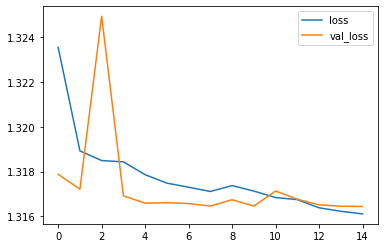

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [10]:
test_steps = test_gen.samples // BATCH_SIZE

test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)
print('\naccuracy:', test_acc, 'loss: ',test_loss)

207/207 [==============================] - 84s 405ms/step - loss: 1.3158 - f1_macro: 0.1313

accuracy: 0.13134461641311646 loss:  1.3157798051834106


In [11]:
predict = model.predict(test_gen, steps=test_steps)
y_hat = np.argmax(predict, axis=1)
y_hat[:20]

207/207 [==============================] - 89s 429ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
test_labels_df = pd.DataFrame()
test_labels_df[['class']] = test_data[['class']]

change = {
'0' : 0,
'1' : 1,
'2' : 2,
'3' : 3,
}

test_labels_df['class'] = test_labels_df['class'].map(change)
test_labels_df = test_labels_df[ : test_steps*BATCH_SIZE]


y_test = np.array(test_labels_df['class'])
y_test[:20]

array([1, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 3])

## Classification Report

              precision    recall  f1-score   support

           0       0.36      1.00      0.53       295
           1       0.00      0.00      0.00       269
           2       0.00      0.00      0.00       149
           3       0.00      0.00      0.00       115

    accuracy                           0.36       828
   macro avg       0.09      0.25      0.13       828
weighted avg       0.13      0.36      0.19       828
 



/home/joao/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joao/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

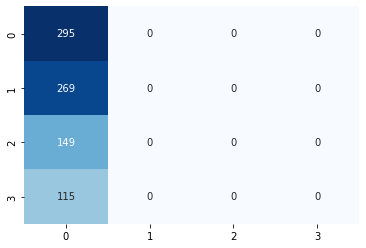

In [13]:
print(classification_report(y_test, y_hat), '\n')
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)

In [16]:
model.save('./model/')

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets
